<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Content-list" data-toc-modified-id="Content-list-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Content list</a></span></li><li><span><a href="#import-libraries-and-data" data-toc-modified-id="import-libraries-and-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>import libraries and data</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#preprocessing" data-toc-modified-id="preprocessing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>preprocessing</a></span><ul class="toc-item"><li><span><a href="#normalization" data-toc-modified-id="normalization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>normalization</a></span><ul class="toc-item"><li><span><a href="#cleaning" data-toc-modified-id="cleaning-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>cleaning</a></span><ul class="toc-item"><li><span><a href="#establish-regex-to-check-if-review-is-cleaned" data-toc-modified-id="establish-regex-to-check-if-review-is-cleaned-4.1.1.1"><span class="toc-item-num">4.1.1.1&nbsp;&nbsp;</span>establish regex to check if review is cleaned</a></span></li><li><span><a href="#remove-html-syntax" data-toc-modified-id="remove-html-syntax-4.1.1.2"><span class="toc-item-num">4.1.1.2&nbsp;&nbsp;</span>remove html syntax</a></span></li><li><span><a href="#remove-url" data-toc-modified-id="remove-url-4.1.1.3"><span class="toc-item-num">4.1.1.3&nbsp;&nbsp;</span>remove url</a></span></li><li><span><a href="#standardise-casing-by-applying-lower()" data-toc-modified-id="standardise-casing-by-applying-lower()-4.1.1.4"><span class="toc-item-num">4.1.1.4&nbsp;&nbsp;</span>standardise casing by applying lower()</a></span></li><li><span><a href="#Fix-contractions" data-toc-modified-id="Fix-contractions-4.1.1.5"><span class="toc-item-num">4.1.1.5&nbsp;&nbsp;</span>Fix contractions</a></span></li><li><span><a href="#remove-stopwords" data-toc-modified-id="remove-stopwords-4.1.1.6"><span class="toc-item-num">4.1.1.6&nbsp;&nbsp;</span>remove stopwords</a></span></li><li><span><a href="#remove-all-symbols" data-toc-modified-id="remove-all-symbols-4.1.1.7"><span class="toc-item-num">4.1.1.7&nbsp;&nbsp;</span>remove all symbols</a></span></li></ul></li><li><span><a href="#Tokenization-+-Lemmatization-or-stemming" data-toc-modified-id="Tokenization-+-Lemmatization-or-stemming-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Tokenization + Lemmatization or stemming</a></span></li><li><span><a href="#export-cleaned-df" data-toc-modified-id="export-cleaned-df-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>export cleaned df</a></span></li></ul></li><li><span><a href="#Vectorization" data-toc-modified-id="Vectorization-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Vectorization</a></span></li></ul></li><li><span><a href="#model-training-and-evaluating" data-toc-modified-id="model-training-and-evaluating-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>model training and evaluating</a></span></li></ul></div>

# Content list

1. Import 
2. Preprocessing<br>
  - Normalization
    - Cleaning
    - Tokenization
    - Lemmatization
  - Vectorization
    -  Bags of words (one-hot vectorization)
    -  TF-IDF
3. Model training <br>
  - SVM
  - Logistic regression
  - neural network
4. Model Evaluation
  - metric = `accuracy`


# import libraries and data

In [6]:
import numpy as np
import pandas as pd

import re
from bs4 import BeautifulSoup

In [7]:
url = 'https://drive.google.com/file/d/1Cqj5d_LHaV4MAdqDdHHk_7uWopvHNzMP/view?usp=sharing'
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Dataset

In [8]:
# Check the dataset information
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Dataset consists of 50000 observations of two features. 

In [9]:
# View the class distribution of data labels
from collections import Counter 
print (dict(Counter(df['sentiment'])))  # We then examined the data structure of the sentiment column and found that it consisted of two values, each of 25,000 rows.

{'positive': 25000, 'negative': 25000}


Half of the dataset are labelled as positive, while the other half negative. Class distribution is balanced. 

# preprocessing

## normalization


1. cleaning punctuations, syntaxes, URL data, Emojis, wtopwords. 
2. tokenization + lemmatization


### cleaning

1. remove html syntax
2. remove url
3. standardise letter casing
4. fix contractions like I'm, they're,... (optional as they will be removed as part of stopwords as well)
5. remove stopwords
6. remove all non-words non-digit symbols. 

In [10]:
# create a cleaned_df copy to conduct all transformation to remain the original dataframe
cleaned_df = df.copy()

#### establish regex to check if review is cleaned

In [11]:
# define function to check whether they consist of unwanted stuffs with regex
def search_review(target_str, pattern):
  cpat = re.compile(pattern)
  if cpat.search(target_str):
    return True
  else:
    return False

def check_if_contain(data, x, pattern, contain=True):
  # avoiding 'contains_{x}' columns accumulating, set up temp_df
  temp_df = data.copy()
  temp_df[f'contains_{x}'] = temp_df.apply(lambda x: search_review(x['review'], pattern), axis=1)
  return temp_df[temp_df[f'contains_{x}'] == contain]

#### 1. remove html syntax

In [12]:
# clean html
cleaned_df.review = cleaned_df.review.apply(lambda string: BeautifulSoup(string, 'html.parser').get_text())

html_regex = r'<.*?>'
check_if_contain(cleaned_df, 'symbol', html_regex, True)

,review,sentiment,contains_symbol
1513,This all-but-ignored masterpiece is about the ...,positive,True
13736,>>> Great News there is a BBC DVD release sche...,positive,True
22164,In Truffaut book-length interview with Hitchco...,positive,True
27107,One minute into THE UNTOLD and it`s already ri...,negative,True
33891,and quite frankly that just sums it up.It is a...,positive,True
42217,"Well, I guess I'm emotionally attached to this...",positive,True
48617,<-----Minor Spoilers!----->A woman gets pregna...,positive,True


#### 2. remove url

In [13]:
# clean url and check if there's still url
cleaned_df.review = cleaned_df.review.str.replace(r"https://\S+|www\.\S+", '', regex = True)

url_regex = r"https://\S+|www\.\S+"
check_if_contain(cleaned_df, 'url', url_regex, True)

,review,sentiment,contains_url


#### 3. standardise casing by applying lower()

In [14]:
# standardise casing to lower case and check
cleaned_df.review = cleaned_df.review.apply(lambda x: x.lower())

upper_case_regex = r'[A-Z]'
check_if_contain(cleaned_df, 'upper', upper_case_regex, True)

,review,sentiment,contains_upper


#### 4. Fix contractions

actually not required as they will be removed along with stopwords

In [15]:
# or make use of easier regex
# code source from https://gist.github.com/yamanahlawat/4443c6e9e65e74829dbb6b47dd81764a

replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]


class RegexpReplacer(object):
  def __init__(self, patterns=replacement_patterns):
    self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    # regex applies to regex pattern to be replaced
    # repl refers to the replacements
    
  def replace(self, text):
    s = text
    for (pattern, repl) in self.patterns:
      s = re.sub(pattern, repl, s)
    return s

In [16]:
replacer = RegexpReplacer()
cleaned_df.review = cleaned_df.review.apply(lambda x: replacer.replace(x))

In [17]:
contraction_regex = r"(?!\")\[A-Za-z]+('[A-Za-z]*)\b"  
# \b matches word boundary, ensuring regex matches complete word not only part of it
# [A-Za-z]+ matches first part of the word
# ('[A-Za-z]*) matches the contraction part
# (?!\") checks that the it does not detect a quotation mark (") at the beginning and take as contraction

check_if_contain(cleaned_df, "contraction", contraction_regex, True)

,review,sentiment,contains_contraction


#### 5. remove stopwords

reference: https://stackabuse.com/removing-stop-words-from-strings-in-python/#usingpythonsgensimlibrary

In [18]:
! pip install nltk

In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [20]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)
# we can add or remove stopwords to the list

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [22]:
# define a function to remove stopwords from a string
# not compulsory, it can be done by vectorization
def remove_stopwords(s):
    # split the string into a list of words
    words = word_tokenize(s)
    
    # remove stopwords from the list of words
    filtered_words = [w for w in words if w not in stopwords]
    
    # join the filtered words back into a string
    return " ".join(filtered_words)

In [23]:
cleaned_df.review = cleaned_df.review.apply(remove_stopwords)
cleaned_df.review[0]

'one reviewers mentioned watching 1 oz episode hooked . right , exactly happened me.the first thing struck oz brutality unflinching scenes violence , set right word go . trust , show faint hearted timid . show pulls punches regards drugs , sex violence . hardcore , classic use word.it called oz nickname given oswald maximum security state penitentary . focuses mainly emerald city , experimental section prison cells glass fronts face inwards , privacy high agenda . em city home many .. aryans , muslims , gangstas , latinos , christians , italians , irish .... scuffles , death stares , dodgy dealings shady agreements never far away.i would say main appeal show due fact goes shows would dare . forget pretty pictures painted mainstream audiences , forget charm , forget romance ... oz mess around . first episode ever saw struck nasty surreal , could say ready , watched , developed taste oz , got accustomed high levels graphic violence . violence , injustice ( crooked guards sold nickel , in

#### 6. remove all symbols

In [24]:
# clean all that are not words
symbol_regex = r'[^a-z|\s]'
cleaned_df.review = cleaned_df.review.str.replace(symbol_regex, ' ', regex = True)

In [25]:
cleaned_df.review[0]

'one reviewers mentioned watching   oz episode hooked   right   exactly happened me the first thing struck oz brutality unflinching scenes violence   set right word go   trust   show faint hearted timid   show pulls punches regards drugs   sex violence   hardcore   classic use word it called oz nickname given oswald maximum security state penitentary   focuses mainly emerald city   experimental section prison cells glass fronts face inwards   privacy high agenda   em city home many    aryans   muslims   gangstas   latinos   christians   italians   irish      scuffles   death stares   dodgy dealings shady agreements never far away i would say main appeal show due fact goes shows would dare   forget pretty pictures painted mainstream audiences   forget charm   forget romance     oz mess around   first episode ever saw struck nasty surreal   could say ready   watched   developed taste oz   got accustomed high levels graphic violence   violence   injustice   crooked guards sold nickel   in

### 7. Tokenization + Lemmatization or stemming

**Why tokenize first?**<br>
Even though the WordNetLemmatizer class can lemmatize long sentences, tokenization is still typically necessary before lemmatization because it helps to split the sentence into individual words or tokens, which can then be lemmatized more accurately and efficiently.
<br>
<br>

**Lemmatization vs Stemming**<br>
Lemmatization has higher accuracy as it takes context into consideration, compared with stemming. 

In [26]:
#Lemmatize the dataset
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [27]:
def lemmatize_string(s):
  lemmatizer = WordNetLemmatizer()
  # split the string into a list of words (tokenization)
  words = word_tokenize(s)
  
  # lemmatize each word in the list
  lemmas = [lemmatizer.lemmatize(w) for w in words]
  
  # join the lemmas back into a string
  return " ".join(lemmas)

In [28]:
cleaned_df['lemma_review']=cleaned_df['review'].apply(lambda z: lemmatize_string(z))

In [29]:
cleaned_df.lemma_review[0]

'one reviewer mentioned watching oz episode hooked right exactly happened me the first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use word it called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home many aryan muslim gangsta latino christian italian irish scuffle death stare dodgy dealing shady agreement never far away i would say main appeal show due fact go show would dare forget pretty picture painted mainstream audience forget charm forget romance oz mess around first episode ever saw struck nasty surreal could say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard sold nickel inmate kill order get away well mannered middle class inmate turned prison bitch due lack street skill prison 

In [30]:
cleaned_df.review[0]

'one reviewers mentioned watching   oz episode hooked   right   exactly happened me the first thing struck oz brutality unflinching scenes violence   set right word go   trust   show faint hearted timid   show pulls punches regards drugs   sex violence   hardcore   classic use word it called oz nickname given oswald maximum security state penitentary   focuses mainly emerald city   experimental section prison cells glass fronts face inwards   privacy high agenda   em city home many    aryans   muslims   gangstas   latinos   christians   italians   irish      scuffles   death stares   dodgy dealings shady agreements never far away i would say main appeal show due fact goes shows would dare   forget pretty pictures painted mainstream audiences   forget charm   forget romance     oz mess around   first episode ever saw struck nasty surreal   could say ready   watched   developed taste oz   got accustomed high levels graphic violence   violence   injustice   crooked guards sold nickel   in

### export cleaned df

In [31]:
# cleaned_df.to_csv('cleaned_df.csv')

## Vectorization

Preprocessing before  training models
use `cleaned_df` to continue preprocessing
<br>

In this section,`CountVectorizer()` (bags of words) and `TfidfVectorizer()` (TF-IDF) are both explored, but only TF-IDF are used for model training due to its ability to factor in context.  

Vectorisation is an important step in converting human language into data that can be processed by computers.

In [32]:
# split train/test dataset
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# train/test 7/3a
X = cleaned_df.lemma_review
y = cleaned_df.sentiment

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [ ]:
# set up nltk stopwords for english
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('english')

In [33]:
# sklearn CountVectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# https://www.geeksforgeeks.org/using-countvectorizer-to-extracting-features-from-text/
from sklearn.feature_extraction.text import CountVectorizer

# define the tokenizer to use with the CountVectorizer
tokenizer = CountVectorizer().build_tokenizer()

# tokenize the stop words the way that CountVectorizer would to prevent error
# stopwords are the nltk stop words used previously
stop_words_tokens = tokenizer(" ".join(stopwords))

# max_features cannot be too large or not specified, otherwise will be OOM ......
c_vect = CountVectorizer(max_df = 0.8, min_df = 3, tokenizer=word_tokenize, stop_words=frozenset(stop_words_tokens), max_features=5000)

In [34]:
X_countvect_train = pd.DataFrame(c_vect.fit_transform(X_train).toarray(), columns=c_vect.get_feature_names_out())
X_countvect_test = pd.DataFrame(c_vect.transform(X_test).toarray(), columns=c_vect.get_feature_names_out())
X_countvect_train.head()

,a,aaron,abandoned,abc,ability,able,absence,absent,absolute,absolutely,...,yet,york,young,younger,youngster,youth,z,zero,zombie,zone
0,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [35]:
# sklearn TfidfVectorizer
# https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
from sklearn.feature_extraction.text import TfidfVectorizer
t_vect = TfidfVectorizer(max_df = 0.8, min_df = 3, tokenizer=word_tokenize, stop_words=frozenset(stop_words_tokens), max_features=5000)

In [36]:
X_tfidfvect_train = pd.DataFrame(t_vect.fit_transform(X_train).toarray(), columns=t_vect.get_feature_names_out())
X_tfidfvect_test = pd.DataFrame(t_vect.transform(X_test).toarray(), columns=t_vect.get_feature_names_out())
X_tfidfvect_train.head()

,a,aaron,abandoned,abc,ability,able,absence,absent,absolute,absolutely,...,yet,york,young,younger,youngster,youth,z,zero,zombie,zone
0,0.053855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.048122,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.05886,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
def encode_y(y):
  y[y == 'positive'] = 1
  y[y == 'negative'] = 0
  y.astype(int)
  return y

y_train = encode_y(y_train).astype(int)
y_test = encode_y(y_test).astype(int)

# model training and evaluating

Metric score used for evaluation is accuracy as the data has equal class distribution. Other than accuracy, the time used for model training and testing are also measured.

In [38]:
from time import time

In [39]:
# logistic Regression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

t0 = time()    # start time
lr.fit(X_tfidfvect_train, y_train)
print ("training done in %fs" %(time() - t0))   # end of training 

t1 = time() 
lr_accuracy = lr.score(X_tfidfvect_test, y_test)
print ("testing done in %fs" %(time() - t1))
print('logistic regression accuracy:', lr_accuracy)

training done in 6.508801s
testing done in 0.152023s
logistic regression accuracy: 0.8864


In [40]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
mnb=MultinomialNB()

t0 = time()    # start time
mnb.fit(X_tfidfvect_train,y_train)
print ("training done in %fs" %(time() - t0))   # end of training 

t1 = time() 
mnb_accuracy = mnb.score(X_tfidfvect_test, y_test)
print ("testing done in %fs" %(time() - t1))

print('mnb accuracy:', mnb_accuracy)

training done in 0.420483s
testing done in 0.145040s
mnb accuracy: 0.8536666666666667


In [41]:
# neural network
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, 
                    hidden_layer_sizes=(5, 2), random_state=1, max_iter=200)

t0 = time()    # start time
mlp.fit(X_tfidfvect_train, y_train)
print ("training done in %fs" %(time() - t0))   # end of training 

t1 = time() 
mlp_accuracy = mlp.score(X_tfidfvect_test, y_test)
print ("testing done in %fs" %(time() - t1))

print('mlp accuracy:', mlp_accuracy)

training done in 543.840702s
testing done in 0.181042s
mlp accuracy: 0.8795333333333333


c:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Finding feature coefficients for logistic regression model

In [70]:
import matplotlib.pyplot as plt
import matplotlib

coef = pd.Series(lr.coef_.flatten(), index = X_tfidfvect_train.columns)

imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])



Text(0.5, 1.0, 'Top Coefficients for Negative Sentiment in the Logistic Regression Model')

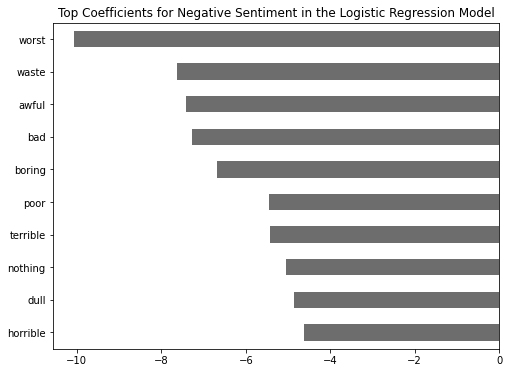

In [79]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
imp_coef.head(10).sort_values(ascending=False).plot(kind = "barh", color = '#6d6d6d')
plt.title("Top Coefficients for Negative Sentiment in the Logistic Regression Model")

Text(0.5, 1.0, 'Top Coefficients for Positive Sentiment in the Logistic Regression Model')

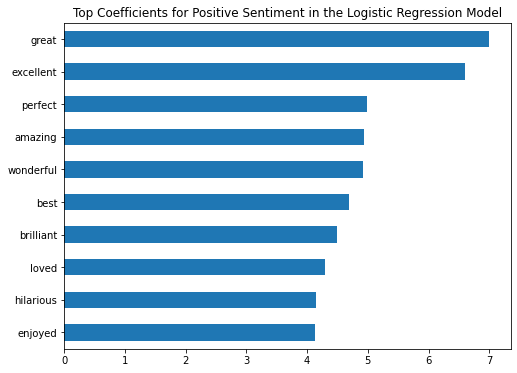

In [77]:
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)
imp_coef.tail(10).sort_values().plot(kind = "barh")
plt.title("Top Coefficients for Positive Sentiment in the Logistic Regression Model")